<a href="https://www.kaggle.com/code/victortrigo/comparative-cnn?scriptVersionId=202178330" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Redes Neuronales Artificiales y Deep Learning

Estudio comparativo en tecnicas de Deep Learning para la clasificacion de imagenes utilizaando Redes Neuronales Convolucionales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf                                                                                              
from tensorflow.keras import models, optimizers, regularizers                                                        
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization    
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 

from tqdm import tqdm
import cv2

from sklearn.utils import shuffle


# ETL

In [2]:
# Load dataset; image and label
directory = '/kaggle/input/rockpaperscissors'
dataset = []
mapping = {"paper": 0, "rock": 1, "scissors": 2}
count = 0
for file in os.listdir(directory):
    if file == 'README_rpc-cv-images.txt' or file == 'rps-cv-images':
        continue
    path = os.path.join(directory,file)
    if not os.listdir(path):
            continue
    for im in os.listdir(path):
        if im.startswith('.'):
            continue
        image = load_img(os.path.join(path,im), target_size = (150,150))
        image = img_to_array(image)
        image = image/255.0
        dataset.append([image, count])
    count = count + 1

In [3]:
data, labels = zip(*dataset)

In [4]:
print("Total no. of images in dataser are {}".format(len(labels)))
c = 0
c1 = 0
c2 = 0
for i in labels:
    if i == 0:
        c += 1
    elif i == 1:
        c1 += 1
    elif i == 2:
        c2 += 1
print("Number of images of rock: {}\nNumber of images of paper: {}\nNumber of images of scissors: {}".format(c1, c, c2))

Total no. of images in dataser are 2188
Number of images of rock: 726
Number of images of paper: 712
Number of images of scissors: 750


In [5]:
labels = to_categorical(labels)
data = np.array(data)
labels = np.array(labels)
print("Data Shape:{}\nLabels shape: {}".format(data.shape, labels.shape))

Data Shape:(2188, 150, 150, 3)
Labels shape: (2188, 3)


Separate dataset to train set, validation set and test set

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,random_state=44)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=44)

In [7]:
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_val:   {}".format(x_val.shape))
print("Shape of x_test:  {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_val:   {}".format(y_val.shape))
print("Shape of y_test:  {}".format(y_test.shape))

Shape of x_train: (1400, 150, 150, 3)
Shape of x_val:   (350, 150, 150, 3)
Shape of x_test:  (438, 150, 150, 3)
Shape of y_train: (1400, 3)
Shape of y_val:   (350, 3)
Shape of y_test:  (438, 3)


## Data Viz

Text(0.5, 1.0, 'Digit : [1. 0. 0.]')

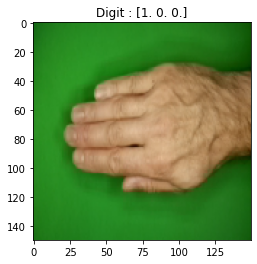

In [8]:
# random visualization
n = np.random.randint(0, np.shape(x_test)[0]) # Generating Random Number

plt.imshow(x_train[n])
plt.title('Digit : ' + str(y_train[n]))

# 1. Build Model

In [9]:
checkpoint = ModelCheckpoint('mejor_modelo.hdf5', 
                             verbose = 1, 
                             save_best_only = True, 
                             monitor = 'val_accuracy'
)

datagen = ImageDataGenerator(rotation_range = 15,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  horizontal_flip = True,
                  vertical_flip = True
)

In [10]:
base_filtros = 32
w_regularizers = 1e-5

In [11]:
# Neural Architecture
model = Sequential()

model.add(Conv2D(base_filtros, (3,3), padding='same', strides=(1,1), kernel_regularizer=regularizers.l2(w_regularizers), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4)))


model.add(Conv2D(2*base_filtros, (3,3), padding='same', strides=(1,1), kernel_regularizer=regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 64)        2

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy']
)

In [13]:
hist = model.fit(x_train, y_train,
                 callbacks=[checkpoint],
                 steps_per_epoch=60,
                 epochs=150,
                 verbose=2,
                 validation_data=(x_val, y_val)
)

Epoch 1/150
60/60 - 11s - loss: 0.8046 - accuracy: 0.8125 - val_loss: 1.1599 - val_accuracy: 0.5086

Epoch 00001: val_accuracy improved from -inf to 0.50857, saving model to mejor_modelo.hdf5
Epoch 2/150
60/60 - 1s - loss: 0.2538 - accuracy: 0.9270 - val_loss: 2.3397 - val_accuracy: 0.3171

Epoch 00002: val_accuracy did not improve from 0.50857
Epoch 3/150
60/60 - 1s - loss: 0.1211 - accuracy: 0.9600 - val_loss: 4.3070 - val_accuracy: 0.3171

Epoch 00003: val_accuracy did not improve from 0.50857
Epoch 4/150
60/60 - 1s - loss: 0.0721 - accuracy: 0.9754 - val_loss: 6.2449 - val_accuracy: 0.3171

Epoch 00004: val_accuracy did not improve from 0.50857
Epoch 5/150
60/60 - 1s - loss: 0.0863 - accuracy: 0.9761 - val_loss: 4.4075 - val_accuracy: 0.3171

Epoch 00005: val_accuracy did not improve from 0.50857
Epoch 6/150
60/60 - 1s - loss: 0.0694 - accuracy: 0.9768 - val_loss: 3.4730 - val_accuracy: 0.3400

Epoch 00006: val_accuracy did not improve from 0.50857
Epoch 7/150
60/60 - 1s - loss: 0.

In [14]:
def train_plot(hist, n):
    epochs = [i for i in range(n)]
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)

    ax[0].plot(epochs, hist.history['accuracy'],     label='Training Accuracy')
    ax[0].plot(epochs, hist.history['val_accuracy'], label= 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, hist.history['loss'],     label = 'Training Loss')
    ax[1].plot(epochs, hist.history['val_loss'], label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.show()

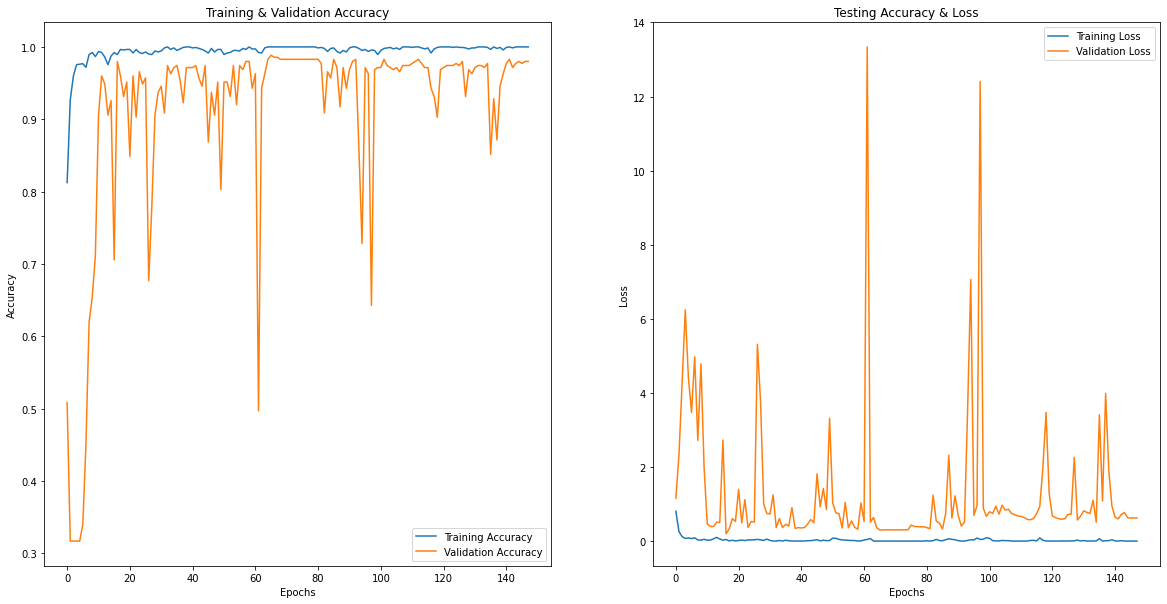

In [15]:
train_plot(hist, 148)

## Desempeño de Modelo Final

In [16]:
# evaluation of the trained model
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

14/14 [==============================] - 0s 16ms/step - loss: 0.2923 - accuracy: 0.9817
Loss of the model is -  0.292305588722229
14/14 [==============================] - 0s 7ms/step - loss: 0.2923 - accuracy: 0.9817
Accuracy of the model is -  98.17351698875427 %


In [17]:
y_pred = model.predict(x_test)
pred = np.argmax(y_pred,axis = 1)
ground = np.argmax(y_test,axis = 1)
from sklearn.metrics import classification_report

print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       139
           1       0.98      0.99      0.98       140
           2       0.98      0.99      0.98       159

    accuracy                           0.98       438
   macro avg       0.98      0.98      0.98       438
weighted avg       0.98      0.98      0.98       438



## Desempeño de Modelo Checkpoint

In [18]:
# evaluation of the best model in training (checkpoint model)
model2 = load_model('./mejor_modelo.hdf5')
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

14/14 [==============================] - 0s 7ms/step - loss: 0.2738 - accuracy: 0.9863
Loss of the model is -  0.27382808923721313
14/14 [==============================] - 0s 8ms/step - loss: 0.2738 - accuracy: 0.9863
Accuracy of the model is -  98.63013625144958 %


In [19]:
y_pred=model2.predict(x_test)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(y_test,axis=1)
from sklearn.metrics import classification_report

print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       139
           1       0.99      1.00      1.00       140
           2       0.97      1.00      0.98       159

    accuracy                           0.99       438
   macro avg       0.99      0.99      0.99       438
weighted avg       0.99      0.99      0.99       438



## Conclusion

El modelo propuesto tuvo un 98.4% de *accuracy* como medida de generalización

# 2. Transfer Learning

Cuatro modelos pre-entrenados: InceptionV3, Xception, VGG16, ResNet50.

In [20]:
def resize_images(x_train, size):
    resized_images = []
    
    for i in range(len(x_train)):
        img = cv2.resize(x_train[i], (size, size))
        resized_images.append(img)
        
    return np.array(resized_images, dtype='float32')

In [21]:
print('Load train data with dimension 150x150x3 :')
x_train_150 = resize_images(x_train, 150)

print('Load test data with dimension 150x150x3 :')
x_test_150 = resize_images(x_test, 150)

print('x_train_150 shape: {}'.format(x_train_150.shape))
print('x_test_150 shape:  {}'.format(x_test_150.shape))

Load train data with dimension 150x150x3 :
Load test data with dimension 150x150x3 :
x_train_150 shape: (1400, 150, 150, 3)
x_test_150 shape:  (438, 150, 150, 3)


In [22]:
print('Load train data with dimension 224x224x3 :')
x_train_224 = resize_images(x_train, 224)

print('Load test data with dimension 224x224x3 :')
x_test_224 = resize_images(x_test, 224)

print('x_train_224 shape: {}'.format(x_train_224.shape))
print('x_test_224 shape:  {}'.format(x_test_224.shape))



Load train data with dimension 224x224x3 :
Load test data with dimension 224x224x3 :
x_train_224 shape: (1400, 224, 224, 3)
x_test_224 shape:  (438, 224, 224, 3)


## InceptionV3

In [23]:
x_train_temp, y_train_temp = shuffle(x_train_150, y_train, random_state=10)

In [24]:
n = len(x_train)
x_val_temp, y_val_temp = x_train_temp[:int(n/5)], y_train_temp[:int(n/5)]

In [25]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(
    include_top = False,
    input_tensor = tf.keras.layers.Input(shape = (150, 150, 3))
)

for layer in inception_model.layers:
  layer.trainable = False

inception_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 74, 74, 32)   96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 74, 74, 32)   0           batch_normalization_2[0][0]      
______________________

In [26]:
last_layers= inception_model.get_layer("mixed7")
last_output = last_layers.output

In [27]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation= "softmax")(x)

inception_model_t = tf.keras.Model(inception_model.input, x)

inception_model_t.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
inception_model_t.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 74, 74, 32)   96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 74, 74, 32)   0           batch_normalization_2[0][0]      
______________________________________________________________________________________________

In [28]:
history_inception = inception_model_t.fit(
    x_train_temp, y_train_temp,
    batch_size = 128,
    epochs = 5,
    validation_data = (x_val_temp, y_val_temp)
)

Epoch 1/5
11/11 [==============================] - 8s 384ms/step - loss: 0.5018 - accuracy: 0.8257 - val_loss: 0.0148 - val_accuracy: 0.9929
Epoch 2/5
11/11 [==============================] - 1s 118ms/step - loss: 0.0265 - accuracy: 0.9886 - val_loss: 0.0045 - val_accuracy: 0.9964
Epoch 3/5
11/11 [==============================] - 1s 118ms/step - loss: 0.0108 - accuracy: 0.9957 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 4/5
11/11 [==============================] - 1s 118ms/step - loss: 0.0086 - accuracy: 0.9979 - val_loss: 5.3144e-05 - val_accuracy: 1.0000
Epoch 5/5
11/11 [==============================] - 1s 118ms/step - loss: 0.0031 - accuracy: 0.9986 - val_loss: 2.5512e-05 - val_accuracy: 1.0000


In [29]:
y_pred = inception_model_t.predict(x_test)
pred = np.argmax(y_pred,axis = 1)
ground = np.argmax(y_test,axis = 1)
from sklearn.metrics import classification_report

print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       139
           1       0.99      1.00      1.00       140
           2       0.99      0.99      0.99       159

    accuracy                           0.99       438
   macro avg       0.99      0.99      0.99       438
weighted avg       0.99      0.99      0.99       438



In [30]:
results = inception_model_t.evaluate(x_test, y_test)

14/14 [==============================] - 0s 27ms/step - loss: 0.0327 - accuracy: 0.9932


## Xception

In [31]:
from tensorflow.keras.applications.xception import Xception

xception_model = Xception(
    include_top = False,
    input_tensor = tf.keras.layers.Input(shape = (150, 150, 3))
)

for layer in inception_model.layers:
  layer.trainable = False

xception_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [32]:
last_layers= xception_model.get_layer("add_11")
last_output = last_layers.output

In [33]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation= "softmax")(x)

xception_model_t = tf.keras.Model(xception_model.input, x)

xception_model_t.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
xception_model_t.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [34]:
history_xception = xception_model_t.fit(
    x_train_temp, y_train_temp,
    batch_size = 128,
    epochs = 5,
    validation_data = (x_val_temp, y_val_temp)
)

Epoch 1/5
11/11 [==============================] - 27s 2s/step - loss: 4.6139 - accuracy: 0.7750 - val_loss: 0.5558 - val_accuracy: 0.9893
Epoch 2/5
11/11 [==============================] - 12s 1s/step - loss: 0.1111 - accuracy: 0.9921 - val_loss: 0.6100 - val_accuracy: 0.9929
Epoch 3/5
11/11 [==============================] - 12s 1s/step - loss: 0.1396 - accuracy: 0.9900 - val_loss: 1.2558 - val_accuracy: 0.9786
Epoch 4/5
11/11 [==============================] - 12s 1s/step - loss: 0.0265 - accuracy: 0.9936 - val_loss: 0.7558 - val_accuracy: 0.9714
Epoch 5/5
11/11 [==============================] - 12s 1s/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.0231 - val_accuracy: 0.9929


In [35]:
y_pred = xception_model_t.predict(x_test)
pred = np.argmax(y_pred,axis = 1)
ground = np.argmax(y_test,axis = 1)
from sklearn.metrics import classification_report

print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       139
           1       0.99      0.99      0.99       140
           2       0.97      1.00      0.98       159

    accuracy                           0.98       438
   macro avg       0.98      0.98      0.98       438
weighted avg       0.98      0.98      0.98       438



In [36]:
results_xception = xception_model_t.evaluate(x_test, y_test)

14/14 [==============================] - 1s 59ms/step - loss: 0.7740 - accuracy: 0.9817


## VGG16

In [37]:
x_train_temp.shape

(1400, 150, 150, 3)

In [38]:
x_train_temp, y_train_temp = shuffle(x_train_224, y_train, random_state=10)

In [39]:
n = len(x_train)
x_val_temp, y_val_temp = x_train_temp[:int(n/5)], y_train_temp[:int(n/5)]

In [40]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16_model = VGG16(
    include_top = False,
    input_tensor = tf.keras.layers.Input(shape = (224, 224, 3))
)

for layer in vgg16_model.layers:
  layer.trainable = False

vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [41]:
last_layers= vgg16_model.get_layer("block3_pool")
last_output = last_layers.output

In [42]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation= "softmax")(x)

vgg16_model_t = tf.keras.Model(vgg16_model.input, x)

vgg16_model_t.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
vgg16_model_t.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [43]:
history_vgg16 = vgg16_model_t.fit(
    x_train_temp, y_train_temp,
    batch_size = 128,
    epochs = 5,
    validation_data = (x_val_temp, y_val_temp)
)

Epoch 1/5
11/11 [==============================] - 39s 2s/step - loss: 967.4214 - accuracy: 0.4329 - val_loss: 336.5162 - val_accuracy: 0.4821
Epoch 2/5
11/11 [==============================] - 5s 488ms/step - loss: 177.5647 - accuracy: 0.5814 - val_loss: 73.8702 - val_accuracy: 0.6679
Epoch 3/5
11/11 [==============================] - 5s 487ms/step - loss: 21.6254 - accuracy: 0.8043 - val_loss: 4.6612 - val_accuracy: 0.9250
Epoch 4/5
11/11 [==============================] - 5s 485ms/step - loss: 4.0082 - accuracy: 0.8800 - val_loss: 0.8425 - val_accuracy: 0.9429
Epoch 5/5
11/11 [==============================] - 5s 486ms/step - loss: 0.7141 - accuracy: 0.9179 - val_loss: 0.2119 - val_accuracy: 0.9464


In [44]:
y_pred = vgg16_model_t.predict(resize_images(x_test, 224))
pred = np.argmax(y_pred, axis = 1)
ground = np.argmax(y_test, axis = 1)
from sklearn.metrics import classification_report

print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       139
           1       0.98      0.89      0.93       140
           2       0.97      0.84      0.90       159

    accuracy                           0.89       438
   macro avg       0.91      0.90      0.90       438
weighted avg       0.91      0.89      0.90       438



In [45]:
results = vgg16_model_t.evaluate(resize_images(x_test, 224), y_test)

14/14 [==============================] - 1s 96ms/step - loss: 1.0805 - accuracy: 0.8950


## ResNet50

In [46]:
from tensorflow.keras.applications.resnet50 import ResNet50


resnet50_model = ResNet50(
    include_top = False,
    input_tensor = tf.keras.layers.Input(shape = (224, 224, 3))
)

for layer in resnet50_model.layers:
  layer.trainable = False

resnet50_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [47]:
last_layers= resnet50_model.get_layer("conv5_block2_out")
last_output = last_layers.output

In [48]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation= "softmax")(x)

resnet50_model_t = tf.keras.Model(resnet50_model.input, x)

resnet50_model_t.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
resnet50_model_t.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [49]:
history_resnet50 = resnet50_model_t.fit(
    x_train_temp, y_train_temp,
    batch_size = 128,
    epochs = 5,
    validation_data = (x_val_temp, y_val_temp)
)


Epoch 1/5
11/11 [==============================] - 14s 864ms/step - loss: 13.5216 - accuracy: 0.3286 - val_loss: 3.0209 - val_accuracy: 0.3143
Epoch 2/5
11/11 [==============================] - 5s 484ms/step - loss: 2.0446 - accuracy: 0.3500 - val_loss: 1.2360 - val_accuracy: 0.3214
Epoch 3/5
11/11 [==============================] - 5s 489ms/step - loss: 1.1102 - accuracy: 0.3607 - val_loss: 1.0917 - val_accuracy: 0.3214
Epoch 4/5
11/11 [==============================] - 5s 493ms/step - loss: 1.0883 - accuracy: 0.3300 - val_loss: 1.0905 - val_accuracy: 0.2964
Epoch 5/5
11/11 [==============================] - 5s 489ms/step - loss: 1.0849 - accuracy: 0.3786 - val_loss: 1.0864 - val_accuracy: 0.3214


In [50]:
y_pred = resnet50_model_t.predict(resize_images(x_test, 224))
pred = np.argmax(y_pred, axis = 1)
ground = np.argmax(y_test, axis = 1)
from sklearn.metrics import classification_report

print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       139
           1       0.00      0.00      0.00       140
           2       0.36      1.00      0.53       159

    accuracy                           0.36       438
   macro avg       0.12      0.33      0.18       438
weighted avg       0.13      0.36      0.19       438



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
results = resnet50_model_t.evaluate(resize_images(x_test, 224), y_test)

14/14 [==============================] - 1s 92ms/step - loss: 1.0776 - accuracy: 0.3630


# Resultados

Tanto los modelos InceptionV3, Xception, VGG16 tuvieron un gran desempeño con *accuracy* de $98%$ aproximadamente cada una como medida de generalización. En cambio, ResNet50 tuvo un *accuracy* de $36%$, se concluye que ResNet50 no es un modelo apropiado para este problema.